In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from evasion_guidance.dataset.evasion_dataset import EvasionDataset
from tqdm import tqdm
import yaml

In [2]:
config_path = "../params/bc_train.yaml"
with open(config_path, "r") as file_object:
    config = yaml.load(file_object,Loader=yaml.SafeLoader)

In [3]:
device = config['device']
data_config = config['data']
num_data = data_config['num_data']
params_path = data_config['params_path']
refined_data_path = data_config['refined_data_path']
coarse_data_path = data_config['coarse_data_path']
dataset = EvasionDataset(refined_data_path, coarse_data_path, params_path, num_data, device=device)

Loading demonstrations: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

Number of data:  530
Finished creating dataset.


In [4]:
features, labels = dataset[0]

train_config = config['train']
# Split dataset into training and validation sets
train_size = int(data_config['training_data_ratio'] * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = train_config['batch_size']
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [12]:
dataset.dataframe.iloc[0]

demonstration_id                                                     0
timestep                                                             0
x                                                           499.999999
y                                                                500.0
yaw                                                           -0.10931
heat_map             [[[0.0002510144840925932, 0.000426456594141200...
risk                                                          0.082603
goal                           [14.868748516852047, 857.3466108776156]
hx                                                          -14.507564
hy                                                          -66.146206
desired_path         [[4.81861192735596, -1.372448965077126], [7.55...
desired_path_risk    [0.2159409166303106, 0.07753384950832004, 0.05...
Name: 0, dtype: object

In [5]:
train_features, train_labels = next(iter(train_loader))

In [8]:
dataset.dataframe

,demonstration_id,timestep,x,y,yaw,heat_map,risk,goal,hx,hy,desired_path,desired_path_risk
0,0,0,499.999999,500.000000,-0.109310,"[[[0.0002510144840925932, 0.000426456594141200...",0.082603,"[14.868748516852047, 857.3466108776156]",-14.507564,-66.146206,"[[4.81861192735596, -1.372448965077126], [7.55...","[0.2159409166303106, 0.07753384950832004, 0.05..."
1,0,1,504.818611,498.627551,-0.633398,"[[[5.0152291208860333e-08, 4.1632372216326985e...",0.215941,"[14.868748516852047, 857.3466108776156]",-22.091065,-68.989436,"[[2.735095934866422, -4.229286419692812], [3.2...","[0.07753384950832004, 0.052002058779610734, 0...."
2,0,2,507.553707,494.398265,-1.288670,"[[[0.47711390256881714, 0.543350875377655, 0.6...",0.077534,"[14.868748516852047, 857.3466108776156]",-27.719654,-68.883144,"[[0.5249375687706106, -5.012576679982658], [0....","[0.052002058779610734, 0.04907201425494003, 0...."
3,0,3,508.078644,489.385688,-1.588876,"[[[0.01889834925532341, 0.02733960933983326, 0...",0.052002,"[14.868748516852047, 857.3466108776156]",-31.296387,-67.876202,"[[-0.47652725826583264, -5.0185827036571595], ...","[0.04907201425494003, 0.05062491310276826, 0.0..."
4,0,4,507.602117,484.367105,-1.729773,"[[[0.0032900862861424685, 0.002871388336643576...",0.049072,"[14.868748516852047, 857.3466108776156]",-34.099582,-66.710291,"[[-1.0276966727238346, -4.934633356090387], [-...","[0.05062491310276826, 0.054539960409800435, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...
525,2,90,861.017299,492.279138,0.428557,"[[[0.0024540883023291826, 0.002198455855250358...",0.157303,"[105.36076578981191, 650.440780963177]",18.127319,8.796979,"[[4.566611553095754, 2.126818807613631], [9.10...","[0.12823292354594487, 0.10593092215630195, 0.0..."
526,2,91,865.583910,494.405957,0.442626,"[[[0.0010179139208048582, 0.000858778133988380...",0.128233,"[105.36076578981191, 650.440780963177]",13.560707,6.670160,"[[4.539690996978948, 2.183669909219418], [9.05...","[0.10593092215630195, 0.08859085344456138, 0.0..."
527,2,92,870.123601,496.589627,0.453577,"[[[0.0005756561877205968, 0.000457378162536770...",0.105931,"[105.36076578981191, 650.440780963177]",9.021016,4.486490,"[[4.5186882266600605, 2.226813082889862], [9.0...","[0.08859085344456138, 0.07495594358821876, 0.0..."
528,2,93,874.642289,498.816440,0.461806,"[[[0.00021390040637925267, 0.00016328718629665...",0.088591,"[105.36076578981191, 650.440780963177]",4.502328,2.259677,"[[4.5023282137136675, 2.2596773150992817], [4....","[0.07495594358821876, 0.07495594358821876, 0.0..."


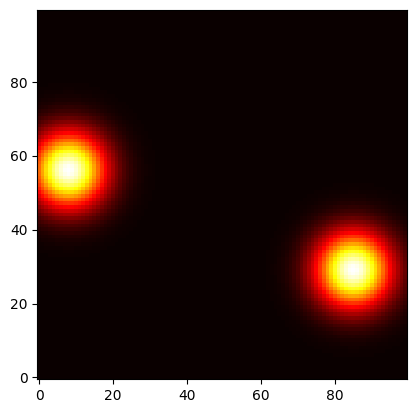

In [10]:
plt.close()
plt.imshow(dataset.dataframe.iloc[50]['heat_map'].squeeze(), cmap='hot', interpolation='nearest', origin="lower")
plt.show()